# Part 1: A Small Example

## Investigating and testing the propagating flux ratio method

In this section, we introduce a small, self-contained piece of fire modeling code: the **propagating flux ratio**.

---

## Goals
* Use a method from production code for our `fire_model` code base
* Explore how output changes across ranges of fuel packing (`beta`) and surface area to volume ratios (`sav`)
* Introduce the concept of **functional testing** for scientific software: small, isolated tests of behavior, not necessarily pass/fail

---


## A primer on fire behavior

The equations in our source code come mainly from several scentific publications, including the original [Rothermel (1972)](https://research.fs.usda.gov/treesearch/32533) fire behavior model.
The aim of this model is to predict fire spread for wildland fuels.

Assuming an ignition event has occurred (e.g., lightning strike, etc.), the 
fire rate of spread ($ROS$, m min$^{-1}$) can be modeled as the ratio between the heat flux from the flaming front (i.e., the energy available to heat unburnbed fuel) to the 
heat required for fuel ignition.

$$
\text{ROS} = \frac{\text{energy available to heat unburned fuel}}{\text{heat required for fuel ignition}}
$$

The available energy is based on the heat given off by fuel when it is combusted (J kg$^{-1}$) as well as the rate at which the fuel is being burned (kg area$^{-1}$ time$^{-1}$). The heat required is baed on fuel physical and chemical properties, such as bulk density, surface area, mass, and moisture. In Rothermel's model, forward rate of spread ($ROS_f$, m min$^{-1}$), is calculated as:

$$
ROS_f = \frac{I_R \cdot \xi \cdot (1 + \Theta_w)}{\rho_b \cdot \epsilon \cdot Q_{ign}}
$$

* $I_R$ - reaction intensity (kJ m$^2$ min$^{-1}$)
* $\xi$ - propagating flux ratio
* $\Theta_w$ - wind factor
* $\rho_b$ - bulk density of fuel (kg m$^{-2}$)
* $Q_{ign}$ - heat of pre-ignition (kJ kg$^{-1}$)

## Propagating flux ratio

The propagating flux ratio ($\xi$) is the proportion of the total reaction intensity ($I_R$) that actually heats adjacent fuel particles to ignition. It is calculated as:

$$
\xi = \frac{\exp\Big[(0.792 + 3.7597\sigma^{0.5})(\beta + 0.1)\Big]}{192 + 7.9095\sigma}
$$

* $\beta$ - packing ratio (fraction of fuel array volume occupied by fuel)
* $\sigma$ - fuel surface area to volume ratio (/cm)

Below is a figure redrawn from a manuscript describing the Rothermel surface fire spread model. It shows how propagating flux changes with surface area to volume ratio and packing ratio.

![title](../figs/prop_flux_ratio.png)

## Exercise 1.1 Test the propagating flux ratio

Let's start by checking out the source code for this method. It's locating in our `FireEquations` class in `src/fire_model/fire_equations.py`.

```python
@staticmethod
def propagating_flux(beta: float, sav: float) -> float:
    """Calculates propagating flux ratio [unitless]
    Proportion of reaction intensity that heats adjacent fuel particles to ignition
    Equation A2 in Thonicke et al. 2010 and Eq. 42 Rothermel 1972

    Args:
        beta (float): packing ratio [unitless]
        sav (float): fuel surface area to volume ratio [/cm]

    Returns:
        float: propagating flux ratio [unitless]
    """
    return (math.exp((0.792 + 3.7597 * (sav**0.5)) * (beta + 0.1))) / (
        192.0 + 7.9095 * sav
    )
```

We can see that it depends on two input arguments: `beta`, and `sav`, which are floats, and it returns a float. If
we wanted to design some **unit tests** for this method

---

### Quick Sanity Checks
Try evaluating the function for a few inputs:

In [15]:
from fire_model import FireEquations
print(FireEquations.propagating_flux(beta=0.01, sav=70))  # expected ~0.046
print(FireEquations.propagating_flux(beta=0.02, sav=100))  # expected ~0.1

0.046560317065924256
0.10188829079352096


Observe the trends: **increasing** `beta` **or** `SAV` **increases flux**, as physically expected, and as shown in the figure above.

---

<div class="alert alert-block alert-info"><b>Note: </b> Notice how we are using the <em>actual</em> method from our <code>fire_code</code> source directory. This may seem normal in Python code, but you can apply the same logic in lower-level (e.g., Fortran) codebases. Because we are using the production code (and not say something we quickly mocked up) we <em>know</em> this is the behavior that will occur in production runs with this code.</div>

### Exercise 1.2 - Functional Test

Now let’s systematically explore behavior over ranges of `beta` and `SAV`. Instead of testing exact values, we’ll inspect outputs qualitatively:

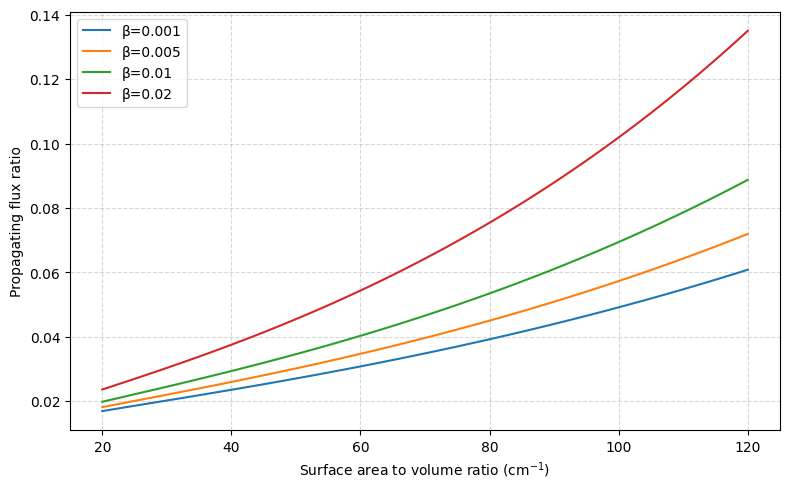

In [42]:
import numpy as np
import matplotlib.pyplot as plt

sav_values = np.linspace(20, 120, 100)
beta_values = [0.001, 0.005, 0.01, 0.02]

plt.figure(figsize=(8, 5))
for beta in beta_values:
    flux = [FireEquations.propagating_flux(beta, sav) for sav in sav_values]
    plt.plot(sav_values, flux, label=f"β={beta}")
plt.xlabel("Surface area to volume ratio (cm$^{-1}$)")
plt.ylabel("Propagating flux ratio")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.legend();

#### Questions to explore:
* Are all flux values positive?
* Does the flux increase monotonically with `beta` and `SAV`?
* Inspect this plot against the one above from Andrews et al. 2018. Do they look similar?
* What if you had some data on propagating flux, how might you use that?

---


### Optional Extension:
Try other methods of exploring the behavior of the `propagating_flux` method. Could you plot `beta` vs. propagating flux for different values of `SAV?`

In [44]:
# TODO: plot beta (x-axis) vs. propagating flux (y-axis)

---
## What We Just Did
* Implemented a **small, isolated scientific computation**
* Applied a **functional testing mindset**:
   - Focused on **behavior across parameter ranges** rather than exact pass/fail
   - Explored qualitative trends
   - Used the **production code** rather than a prototype or mock-up
* Compared to "known" values from a paper

---

## Looking Ahead
Next we will:
* Integrate these methods with a `Fuel` object for functional testing over different synthetic fuel classes

In [ ]:
###